<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.shape

(100001, 7)

In [4]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,237030,237030,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0
1,247341,247341,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1
2,246425,246425,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1
3,306985,306985,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1
4,225863,225863,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0


In [5]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [Unnamed: 0, id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [6]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [7]:

df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [8]:
#removing id from X
X=X.drop('id',axis=1)
X.columns

Index(['Unnamed: 0', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [9]:
y=np.array(duplicate)

In [10]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 28)
(70000,)
(30001, 28)
(30001,)


In [12]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
#questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(X_train_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [15]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')

import en_core_web_sm
nlp = en_core_web_sm.load()
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
#df['q1_feats_m'] = list(vecs1)

100%|██████████| 70000/70000 [13:16<00:00, 87.87it/s]


In [16]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
#df['q2_feats_m'] = list(vecs2)

100%|██████████| 30001/30001 [05:45<00:00, 86.95it/s]


In [17]:
first_df=pd.DataFrame(vecs1)
sec_df=pd.DataFrame(vecs2)

In [18]:
from scipy.sparse import hstack
X_train = hstack((X_train.values,first_df))
X_test= hstack((X_test.values,sec_df))
print(X_train.shape)
print(X_test.shape)

(70000, 123)
(30001, 123)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## 4. Machine Learning Models 

In [20]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 123)
Number of data points in test data : (30001, 123)


In [21]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6305714285714286 Class 1:  0.36942857142857144
---------- Distribution of output variable in train data ----------
Class 0:  0.3692543581880604 Class 1:  0.3692543581880604


In [22]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6585577245019245
For values of alpha =  0.0001 The log loss is: 0.6585577245019245
For values of alpha =  0.001 The log loss is: 0.6585577245019245
For values of alpha =  0.01 The log loss is: 0.6585577245019245
For values of alpha =  0.1 The log loss is: 0.5964639489997903
For values of alpha =  1 The log loss is: 0.5998605962235927
For values of alpha =  10 The log loss is: 0.5767803969605458


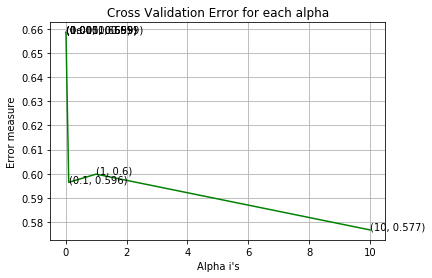

For values of best alpha =  10 The train log loss is: 0.5709142984387781
For values of best alpha =  10 The test log loss is: 0.5767803969605458
Total number of data points : 30001


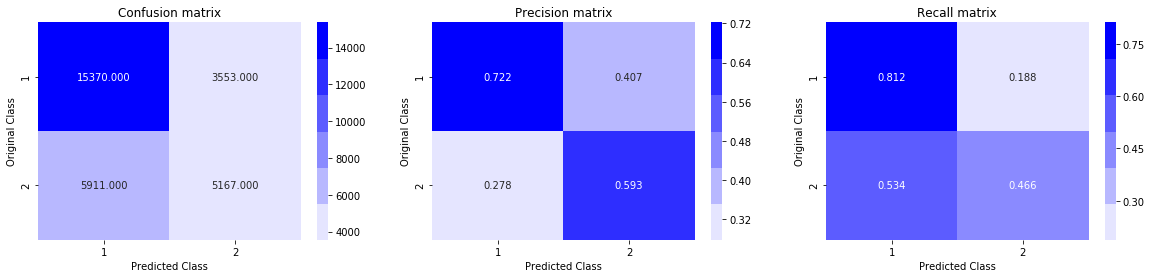

In [23]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.5 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6585577245019245
For values of alpha =  0.0001 The log loss is: 0.6585577245019245
For values of alpha =  0.001 The log loss is: 0.6585577245019245
For values of alpha =  0.01 The log loss is: 0.6585577245019245
For values of alpha =  0.1 The log loss is: 0.6585577245019245
For values of alpha =  1 The log loss is: 0.6585577245019245
For values of alpha =  10 The log loss is: 0.6585577245019245


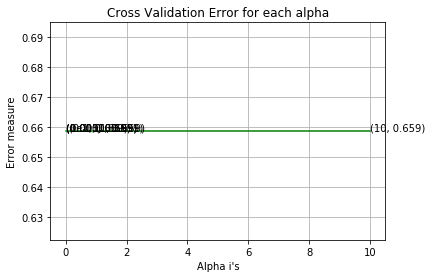

For values of best alpha =  1e-05 The train log loss is: 0.6586508569781894
For values of best alpha =  1e-05 The test log loss is: 0.6585577245019245
Total number of data points : 30001


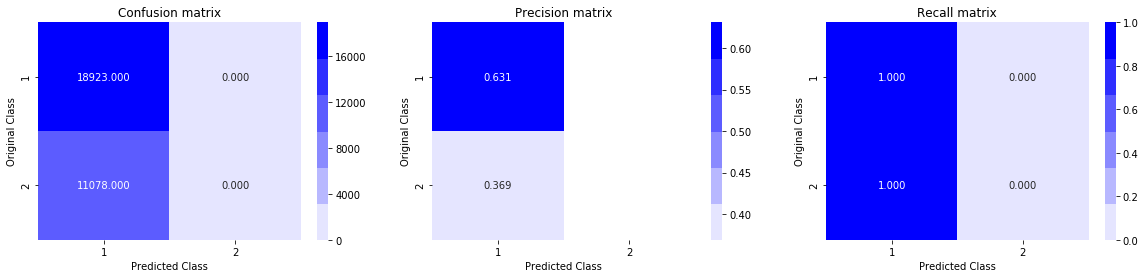

In [27]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.6 XGBoost

In [25]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685549	valid-logloss:0.685697
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.623514	valid-logloss:0.623547
[20]	train-logloss:0.578171	valid-logloss:0.578002
[30]	train-logloss:0.544298	valid-logloss:0.543963
[40]	train-logloss:0.518275	valid-logloss:0.517817
[50]	train-logloss:0.497911	valid-logloss:0.497412
[60]	train-logloss:0.481796	valid-logloss:0.481216
[70]	train-logloss:0.468729	valid-logloss:0.468241
[80]	train-logloss:0.458315	valid-logloss:0.457702
[90]	train-logloss:0.449798	valid-logloss:0.44912
[100]	train-logloss:0.442645	valid-logloss:0.44195
[110]	train-logloss:0.436655	valid-logloss:0.435961
[120]	train-logloss:0.431229	valid-logloss:0.430585
[130]	train-logloss:0.426963	valid-logloss:0.426369
[140]	train-logloss:0.423372	valid-logloss:0.422882
[150]	train-logloss:0.419966	valid-logloss:0.419617
[160]	train-logloss:0.41707	va

Total number of data points : 30001


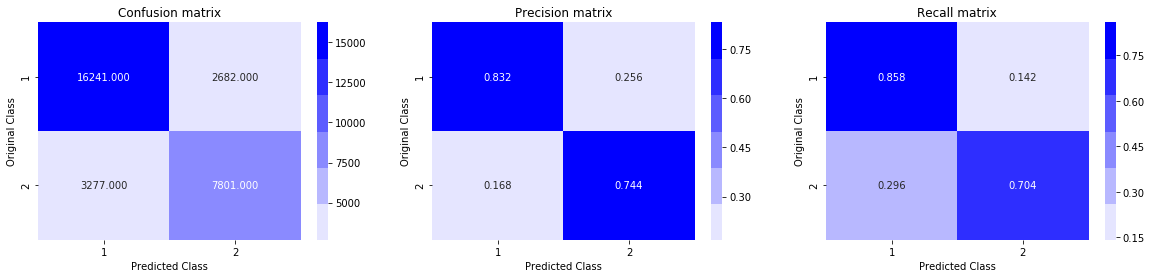

In [26]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)